In [1]:
import pandas as pd
import numpy as np

In [2]:

# df = pd.read_csv('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/data_2.csv', sep = " ", names = ['name', 'value'])

df = pd.read_csv('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/data_2.csv', sep = " ", names = ['name', 'value'])


In [3]:

df.dropna(inplace = True)
df


,name,value
0,a,[0.6152792 0.57624728 0.97183159 0.30227324 0...
1,q,"[[1.0, 0.99996588008, 0.99989695401, 0.9997925..."
2,det_J,"[0.0, 0.0, 0.0, 0.0, -2.53263925567196e-87, 2...."
3,a,[0.42157321 0.04321076 0.28883865 0.53631535 0...
4,q,"[[1.0, 0.99999984126, 0.99999948152, 0.9999988..."
...,...,...
2995,q,"[[1.0, 0.99991970255, 0.99975684995, 0.9995091..."
2996,det_J,"[0.0, 0.0, 0.0, 0.0, 1.4138451607417442e-86, -..."
2997,a,[0.18525751 0.06743073 0.86360801 0.0865571 0...
2998,q,"[[1.0, 0.99999969828, 0.9999992522, 0.99999881..."


In [4]:
df2 = pd.DataFrame()
for r in range(len(df)):
    if r % 3 == 0:
        df0 = df.iloc[r,1:]
        df0.value
        df0 = df0.str.strip('[[[ ')
        df0 = df0.str.strip('[]')
        df0 = df0.value.split()
        df0 = np.array(df0,dtype=float)
        df2 = df2.append(pd.DataFrame(df0))




In [5]:
df2.head(12)
df2.shape

(6000, 1)

In [6]:
df2.shape

(6000, 1)

In [7]:
df3 = pd.DataFrame()
for i in range(len(df)):
    if i % 3 == 1:
        df1 = df.iloc[i,1:]
        df1 = df1.value
        df1 = df1.replace('[','')
        df1 = df1.replace(']','')
        df1 = df1.split(',')
        df1 = np.array(df1,dtype=float)
        df3 = df3.append(pd.DataFrame(df1))


In [8]:
df3.shape

(1600000, 1)

In [9]:
type(df3)

pandas.core.frame.DataFrame

In [10]:
q_array = df3.to_numpy()
tmp = []
for r in q_array:
    tmp.append(np.transpose(np.asarray([r])).astype(np.float32))
q_array = np.asarray(tmp.copy())
type(q_array)

numpy.ndarray

In [11]:
q_array = q_array.reshape(1000,16,100)
q_array.shape

(1000, 16, 100)

In [12]:
a_array = df2.to_numpy()
tmp2 = []
for i in a_array:
    tmp2.append(np.transpose(np.asarray([i])).astype(np.float32))
a_array = np.asarray(tmp2.copy())

In [13]:
a_array = a_array.reshape(1000,6)
a_array.shape

(1000, 6)

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [15]:
train_x = (q_array[0:800,:,:]).astype(np.float32) # training data from csv/pandas (80% of existing data?)
test_x = (q_array[800:1000,:,:]).astype(np.float32) # test data from csv/pandas (remaining ~20% of data)
test_x = np.expand_dims(test_x, 1) # add dimension for neural net

train_y = (a_array[0:800,:]).astype(np.float32)
test_y = (a_array[800:1000,:]).astype(np.float32)

x_test_tensor = torch.from_numpy(test_x)
y_test_tensor = torch.from_numpy(test_y)
test_data = [(x_test_tensor[i],y_test_tensor[i]) for i in range(x_test_tensor.shape[0])]

# print(train_x.shape)
# print(x_test_tensor.shape)
# print(y_test_tensor.shape)
# print(len(test_data))


In [16]:
x_train_tensor = torch.from_numpy(train_x)
y_train_tensor = torch.from_numpy(train_y)

# xtrain_tensor = torch.utils.data.TensorDataset(train_x)
# ytrain_tensor = torch.utils.data.TensorDataset(train_y)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, 
                                             shuffle=True)


for batch, (x, y) in enumerate(train_loader):
    print("batch", batch)
    print("Shape of x: ", x.shape, x.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break


# trainset_x = torch.utils.data.DataLoader(train_x, batch_size=10, shuffle=True)
# testset_x = torch.utils.data.DataLoader(test_x, batch_size=10, shuffle=True)
# trainset_y = torch.utils.data.DataLoader(train_y, batch_size=10, shuffle=True)
# testset_y = torch.utils.data.DataLoader(test_y, batch_size=10, shuffle=True)

batch 0
Shape of x:  torch.Size([100, 16, 100]) torch.float32
Shape of y:  torch.Size([100, 6]) torch.float32


In [17]:
import torch.nn.functional as F

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
            
        self.ls = nn.LSTM(16,32,2, batch_first = True)
        self.linear = nn.Linear(32,6)
            

    def forward(self, x):
        batch_size = x.shape[0] 
        x = self.flatten(x)
        x = torch.reshape(x, (batch_size, 100, 16)) 
        output,(h,c) = self.ls(x)
        output = self.linear(h[-1,...]) 
        return nn.Sigmoid()(output)

model = Net()
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ls): LSTM(16, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=6, bias=True)
)


In [19]:
### loss function and optimizer for training 
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### Functions for training and testing the model
def train(dataloader, model, loss_fn, optimizer,loss_list):
    size = len(dataloader.dataset)
    for batch, (x,y) in enumerate(dataloader):

#         print("batch ", batch)
#         print("Shape of x: ", x.shape)
#         print("Shape of y: ", y.shape)
    
        # Compute prediction error
        pred = model(x)
#         print("pred", pred)
#         print("y", y)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
        if batch % 2 == 0:
#             loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model,test_loss_list):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
#             print("pred",pred.shape)
#             print("y",y.shape)
            test_loss += loss_fn(pred, y)
    print(f"Test Error: Loss = {test_loss:>8f} \n")
    test_loss_list.append(test_loss)
    return test_loss_list

In [20]:
### Train the model
epochs = 200
loss_list=[]
test_loss_list=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_list = train(train_loader, model, loss_fn, optimizer,loss_list)
    test_loss_list = test(test_loader, model, test_loss_list)

Epoch 1
-------------------------------
loss: 0.085192  [    0/  800]
loss: 0.082811  [  200/  800]
loss: 0.077863  [  400/  800]
loss: 0.088803  [  600/  800]
Test Error: Loss = 0.171954 

Epoch 2
-------------------------------
loss: 0.082359  [    0/  800]
loss: 0.085543  [  200/  800]
loss: 0.082167  [  400/  800]
loss: 0.085189  [  600/  800]
Test Error: Loss = 0.172849 

Epoch 3
-------------------------------
loss: 0.088290  [    0/  800]
loss: 0.083696  [  200/  800]
loss: 0.079401  [  400/  800]
loss: 0.081130  [  600/  800]
Test Error: Loss = 0.172458 

Epoch 4
-------------------------------
loss: 0.087447  [    0/  800]
loss: 0.087434  [  200/  800]
loss: 0.083302  [  400/  800]
loss: 0.084401  [  600/  800]
Test Error: Loss = 0.172194 

Epoch 5
-------------------------------
loss: 0.084649  [    0/  800]
loss: 0.087554  [  200/  800]
loss: 0.080498  [  400/  800]
loss: 0.086329  [  600/  800]
Test Error: Loss = 0.173345 

Epoch 6
-------------------------------
loss: 0.08

loss: 0.052821  [    0/  800]
loss: 0.051792  [  200/  800]
loss: 0.053339  [  400/  800]
loss: 0.049544  [  600/  800]
Test Error: Loss = 0.109535 

Epoch 45
-------------------------------
loss: 0.049332  [    0/  800]
loss: 0.049622  [  200/  800]
loss: 0.048183  [  400/  800]
loss: 0.048775  [  600/  800]
Test Error: Loss = 0.101895 

Epoch 46
-------------------------------
loss: 0.053022  [    0/  800]
loss: 0.046000  [  200/  800]
loss: 0.048727  [  400/  800]
loss: 0.044849  [  600/  800]
Test Error: Loss = 0.102147 

Epoch 47
-------------------------------
loss: 0.049187  [    0/  800]
loss: 0.046869  [  200/  800]
loss: 0.053718  [  400/  800]
loss: 0.044268  [  600/  800]
Test Error: Loss = 0.099968 

Epoch 48
-------------------------------
loss: 0.049477  [    0/  800]
loss: 0.048263  [  200/  800]
loss: 0.049365  [  400/  800]
loss: 0.048947  [  600/  800]
Test Error: Loss = 0.104351 

Epoch 49
-------------------------------
loss: 0.045838  [    0/  800]
loss: 0.050439 

loss: 0.037911  [  200/  800]
loss: 0.039692  [  400/  800]
loss: 0.039440  [  600/  800]
Test Error: Loss = 0.088878 

Epoch 88
-------------------------------
loss: 0.037690  [    0/  800]
loss: 0.036846  [  200/  800]
loss: 0.044249  [  400/  800]
loss: 0.043115  [  600/  800]
Test Error: Loss = 0.088770 

Epoch 89
-------------------------------
loss: 0.042504  [    0/  800]
loss: 0.039700  [  200/  800]
loss: 0.039556  [  400/  800]
loss: 0.040995  [  600/  800]
Test Error: Loss = 0.090041 

Epoch 90
-------------------------------
loss: 0.038563  [    0/  800]
loss: 0.035925  [  200/  800]
loss: 0.042462  [  400/  800]
loss: 0.036571  [  600/  800]
Test Error: Loss = 0.084786 

Epoch 91
-------------------------------
loss: 0.039474  [    0/  800]
loss: 0.036911  [  200/  800]
loss: 0.038549  [  400/  800]
loss: 0.035327  [  600/  800]
Test Error: Loss = 0.089809 

Epoch 92
-------------------------------
loss: 0.040751  [    0/  800]
loss: 0.035931  [  200/  800]
loss: 0.036086 

loss: 0.027055  [    0/  800]
loss: 0.025211  [  200/  800]
loss: 0.028537  [  400/  800]
loss: 0.026811  [  600/  800]
Test Error: Loss = 0.070674 

Epoch 131
-------------------------------
loss: 0.026960  [    0/  800]
loss: 0.026012  [  200/  800]
loss: 0.024846  [  400/  800]
loss: 0.026467  [  600/  800]
Test Error: Loss = 0.071145 

Epoch 132
-------------------------------
loss: 0.026434  [    0/  800]
loss: 0.027344  [  200/  800]
loss: 0.026109  [  400/  800]
loss: 0.026685  [  600/  800]
Test Error: Loss = 0.070328 

Epoch 133
-------------------------------
loss: 0.027894  [    0/  800]
loss: 0.026446  [  200/  800]
loss: 0.029560  [  400/  800]
loss: 0.022219  [  600/  800]
Test Error: Loss = 0.075123 

Epoch 134
-------------------------------
loss: 0.028991  [    0/  800]
loss: 0.025465  [  200/  800]
loss: 0.026994  [  400/  800]
loss: 0.024497  [  600/  800]
Test Error: Loss = 0.071920 

Epoch 135
-------------------------------
loss: 0.023414  [    0/  800]
loss: 0.02

loss: 0.019003  [  200/  800]
loss: 0.021478  [  400/  800]
loss: 0.019744  [  600/  800]
Test Error: Loss = 0.067957 

Epoch 174
-------------------------------
loss: 0.020917  [    0/  800]
loss: 0.017635  [  200/  800]
loss: 0.021313  [  400/  800]
loss: 0.016984  [  600/  800]
Test Error: Loss = 0.066979 

Epoch 175
-------------------------------
loss: 0.016471  [    0/  800]
loss: 0.019733  [  200/  800]
loss: 0.019047  [  400/  800]
loss: 0.021726  [  600/  800]
Test Error: Loss = 0.069178 

Epoch 176
-------------------------------
loss: 0.018385  [    0/  800]
loss: 0.019585  [  200/  800]
loss: 0.028125  [  400/  800]
loss: 0.021698  [  600/  800]
Test Error: Loss = 0.069225 

Epoch 177
-------------------------------
loss: 0.020339  [    0/  800]
loss: 0.020616  [  200/  800]
loss: 0.018705  [  400/  800]
loss: 0.019409  [  600/  800]
Test Error: Loss = 0.064639 

Epoch 178
-------------------------------
loss: 0.021848  [    0/  800]
loss: 0.017761  [  200/  800]
loss: 0.01

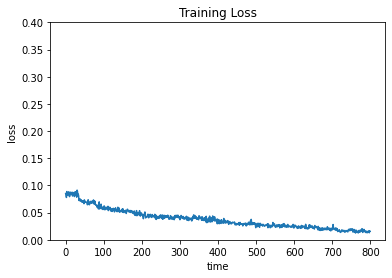

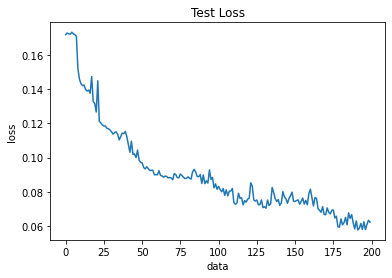

In [21]:
plt.figure()
plt.plot(loss_list)
axes = plt.gca()
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('loss')
axes.set_ylim([0,0.4])
plt.show()

plt.figure()
plt.plot(test_loss_list)
axes = plt.gca()
plt.title('Test Loss')
plt.xlabel('data')
plt.ylabel('loss')
plt.show()

In [28]:
n = np.random.randint(0,200)
pred = model(x_test_tensor[n])
print(pred[0])
print(y_test_tensor[n])

tensor([0.6677, 0.4278, 0.2584, 0.7262, 0.5235, 0.6059],
       grad_fn=<SelectBackward>)
tensor([0.6953, 0.6301, 0.3016, 0.8754, 0.6919, 0.3048])
